In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
df = pd.read_csv('crop_data.csv')  # Replace with your actual file path

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Print column names
print("Columns:", df.columns.tolist())

Columns: ['State', 'District', 'Crop', 'Crop_Year', 'Season', 'Area', 'Production', 'Yield']


In [3]:
# Handle missing values
# Numerical: fill with median
df['Area'] = df['Area'].fillna(df['Area'].median())
df['Crop_Year'] = df['Crop_Year'].fillna(df['Crop_Year'].median())
df['Yield'] = df['Yield'].fillna(df['Yield'].median())

# Categorical: fill with mode
df['State'] = df['State'].fillna(df['State'].mode()[0])
df['District'] = df['District'].fillna(df['District'].mode()[0])
df['Crop'] = df['Crop'].fillna(df['Crop'].mode()[0])
df['Season'] = df['Season'].fillna(df['Season'].mode()[0])

# Print missing values after handling
print("Missing Values After Handling:\n", df.isnull().sum())

Missing Values After Handling:
 State            0
District         0
Crop             0
Crop_Year        0
Season           0
Area             0
Production    4948
Yield            0
dtype: int64


In [4]:
# One-hot encode categorical variables (State, Crop, Season)
df = pd.get_dummies(df, columns=['State', 'Crop', 'Season'], drop_first=True)

# Define features and target
X = df.drop(columns=['Yield', 'District'])  # Exclude target and District
y = df['Yield']

# Scale numerical features (Area, Crop_Year)
scaler = StandardScaler()
X[['Area', 'Crop_Year']] = scaler.fit_transform(X[['Area', 'Crop_Year']])

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify split
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (276268, 98) (276268,)
Test set shape: (69068, 98) (69068,)


In [6]:
# Initialize Decision Tree Regressor
base_model = DecisionTreeRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R² Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Validated R² Score: 0.8767843297352498


In [8]:
# Get the best model
model = grid_search.best_estimator_

# Train the model
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

In [9]:
# Evaluate model on test set
print("Test Set Evaluation:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("\nCross-Validation R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean(), "±", cv_scores.std())

Test Set Evaluation:
R² Score: 0.8632305575515874
MAE: 25.566951700959795
RMSE: 342.5591469173955

Cross-Validation R² Scores: [0.7079977  0.45978305 0.19484226 0.69453942 0.87401496]
Mean CV R²: 0.5862354764382942 ± 0.23603037120170253


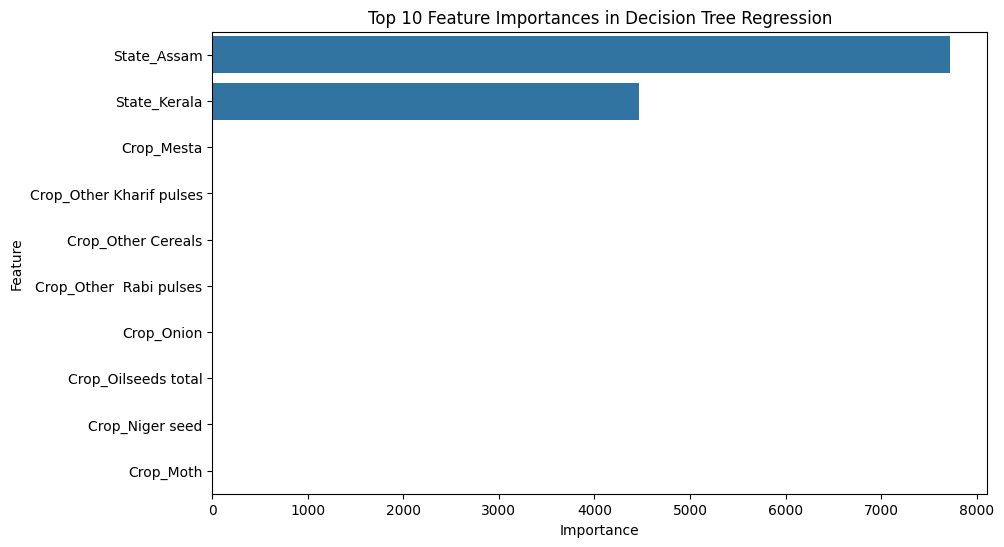

In [10]:
# Calculate and plot feature importance
importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Feature Importances in Decision Tree Regression")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

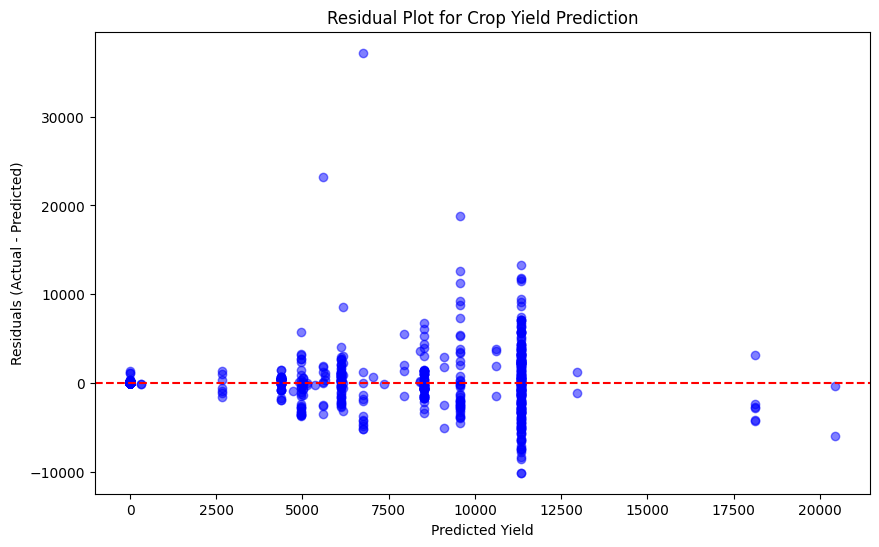

In [15]:
# Residual plot to analyze prediction errors
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Yield")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Crop Yield Prediction")
plt.show()

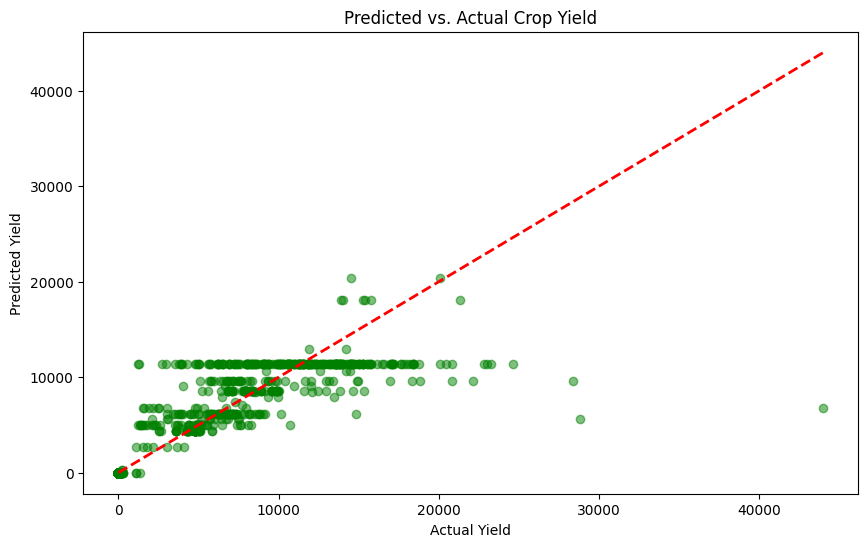

In [16]:
# Scatter plot of predicted vs. actual yields
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs. Actual Crop Yield")
plt.show()

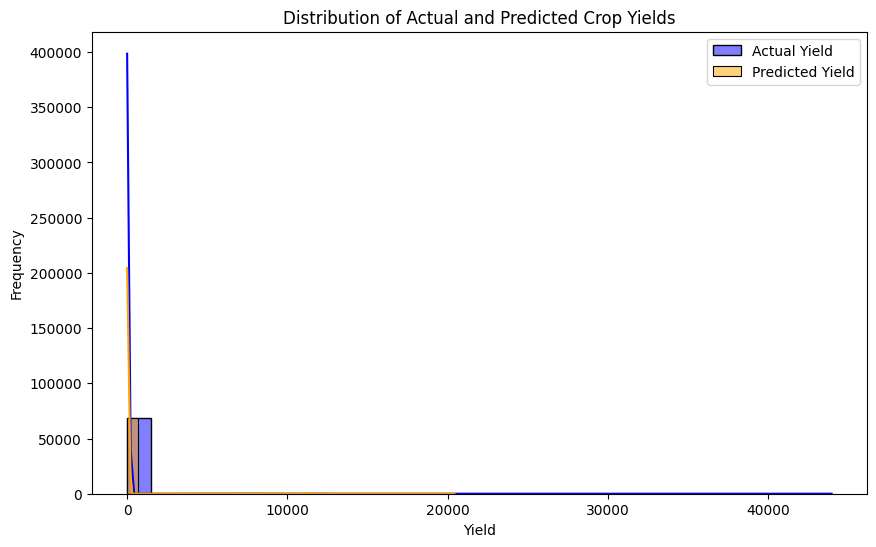

In [17]:
# Distribution plot of predicted and actual yields
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual Yield', alpha=0.5, kde=True, bins=30)
sns.histplot(y_pred, color='orange', label='Predicted Yield', alpha=0.5, kde=True, bins=30)
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.title("Distribution of Actual and Predicted Crop Yields")
plt.legend(loc='upper right')  # Fixed legend location to avoid warning
plt.show()